In [2]:
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import matplotlib.patches as patches
import ast
from collections import Counter
import numpy as np
import scipy
from scipy.ndimage.filters import gaussian_filter

In [12]:
useDEMOfile = True # set to False if you will be providing your own data_path below
data_path = ''     # if you want to provide your own codecharts results file, add it here

if useDEMOfile: 
    data_path = "my_result_3.json"
    
base_path = "." # to access the assets directory/task data for the images

with open(data_path) as f:
    all_data = json.load(f)
    
# the data_path provided will only be one participant worth of data, but usually this will be a list of multiple
# participants worth of data, so for similarity of format, we will wrap the one-participant data in a list
if useDEMOfile:
    all_data = [all_data]
    
print('Using results from %d participant(s)'%(len(all_data)))

Using results from 1 participant(s)


## Organize participant data in a format that makes it easier to analyze ##

In [14]:
def get_data_for_subject(subj_data):
    print('Worker: %s'%(subj_data['workerId']))
    print('took %2.2f min to complete task.'%(subj_data['results']['outputs']['timing']['timeToCompleteFromStartMsec']/60000))
    print('Survey data:',subj_data['results']['outputs']['surveyData'])
    
    # for sanity, check how many images of each type participants saw during the experiment
    tutorial_real = 0
    tutorial_sentinel = 0
    real = 0
    sentinel = 0
    
    # performances
    tut_real_valid = 0
    tut_sent_valid = 0
    exp_real_valid = 0
    exp_sent_valid = 0
    
    # save coordinates attended to
    D = {} # maps image names to coordinates on the image where participants looked
    D_sentinels = {} # map sentinel image names to coordinates on the sentinels where participants looked
    
    input_tasks = subj_data['results']['inputs']['tasks']
    output_tasks = subj_data['results']['outputs']['tasks']
    
    for j in range(len(input_tasks)):
        
        taskID = input_tasks[j]['index']
        im = input_tasks[j]['image']
        taskOutput = output_tasks['%s'%(taskID)]
        
        if input_tasks[j]['flag']=='tutorial_real':
            tutorial_real += 1
            tut_real_valid += taskOutput['isValidCode']
        elif input_tasks[j]['flag']=='tutorial_sentinel':
            tutorial_sentinel += 1
            tut_sent_valid += taskOutput['isValidCode']
        elif input_tasks[j]['flag']=='real':
            real += 1
            exp_real_valid += taskOutput['isValidCode']
            if taskOutput['isValidCode']:
                D[im] = taskOutput['coordinate']
        else:
            sentinel += 1
            exp_sent_valid += taskOutput['isValidCode']
            if taskOutput['isValidCode']:
                D_sentinels[im] = taskOutput['coordinate']

    print('Valid codes entered for %d/%d tutorial images, %d/%d tutorial sentinels, %d/%d experiment images, %d/%d sentinels\n'\
         %(tut_real_valid,tutorial_real,tut_sent_valid,tutorial_sentinel,exp_real_valid,real,exp_sent_valid,sentinel))
    
    return D,D_sentinels

# USAGE: 
#for i in range(len(all_data)):
#    D = get_data_for_subject(all_data[i])

In [15]:
D_coords_fixated = {}
D_sents_fixated = {}

for i in range(len(all_data)):
    D,D_sentinels = get_data_for_subject(all_data[i])
    
    # aggregate the data for later plotting & analysis
    for key in D:
        if key not in D_coords_fixated:
            D_coords_fixated[key] = []
        D_coords_fixated[key].append({'user':all_data[i]['workerId'],'coords':D[key],'time':all_data[i]['results']['inputs']['params']['NUM_MSEC_IMAGE']})
    
    # keep this data for sanity checks
    for key in D_sentinels:
        if key not in D_sents_fixated:
            D_sents_fixated[key] = []
        D_sents_fixated[key].append({'user':all_data[i]['workerId'],'coords':D_sentinels[key]})
        
        

Worker: 
took 2.90 min to complete task.
Survey data: {'gender': 'unspecified', 'ageGroup': 'ageGroup18', 'ethnicity': 'unspecified', 'education': 'unspecified', 'vizExperience': 'unspecified', 'feedback': ''}
Valid codes entered for 1/2 tutorial images, 1/1 tutorial sentinels, 6/8 experiment images, 1/1 sentinels



## Plot individual fixations (one per participant) on top of images ##

Image 0/6: ../assets/task_data\real_images\bucket0\este lauder double ok.jpg


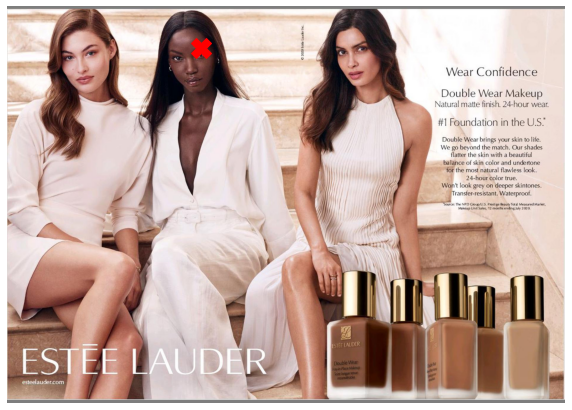

Image 1/6: ../assets/task_data\real_images\bucket0\libre YSL OK.JPG


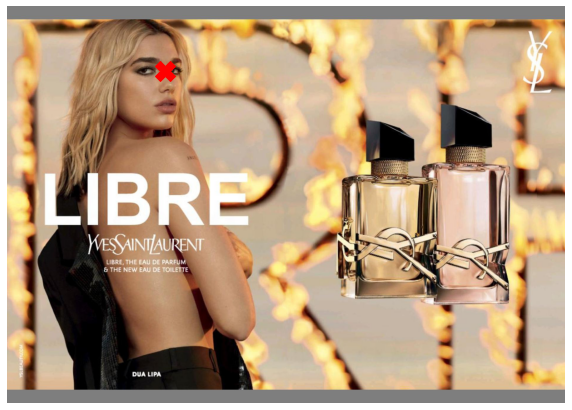

Image 2/6: ../assets/task_data\real_images\bucket0\clinique soin ok.jpg


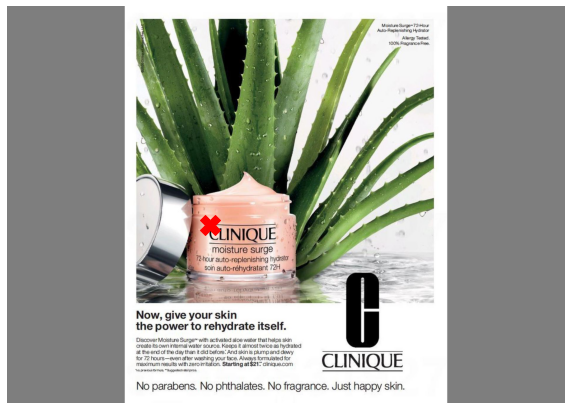

Image 3/6: ../assets/task_data\real_images\bucket0\estee lauder double nuit ok.jpg


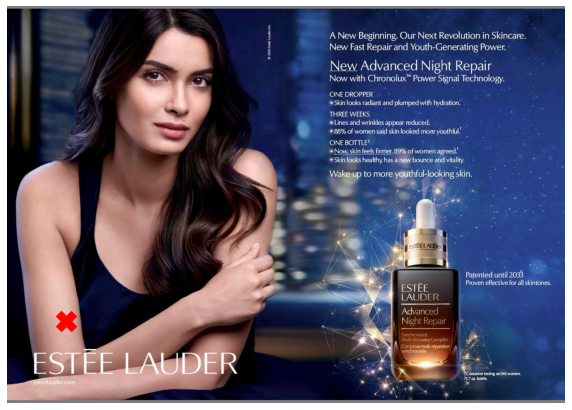

Image 4/6: ../assets/task_data\real_images\bucket0\Forever Dior - Copie.JPG


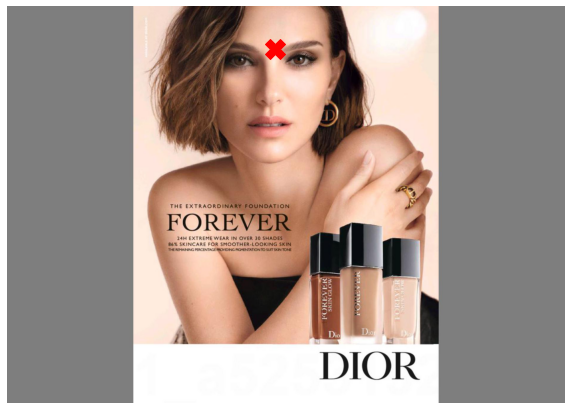

Image 5/6: ../assets/task_data\real_images\bucket0\rouge Dior double.JPG


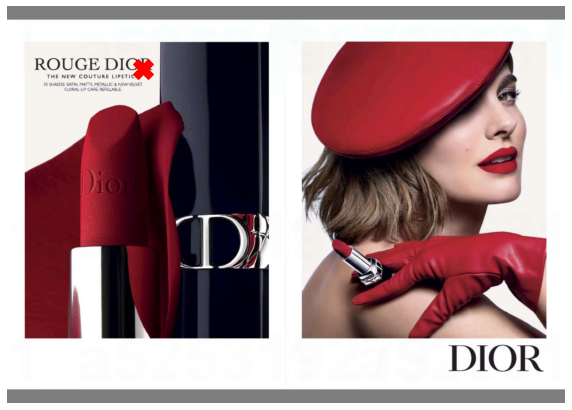

In [16]:
# plot codechart selections directly on image, and color the location by the duration of image presentation
def plot_fixations_on_image(filename,D,withtime=False):
    
    colors = ['r','g','b']
    
    imfilename = os.path.join(base_path, filename)
    im = Image.open(imfilename)
    fig,ax = plt.subplots(1,figsize=(10,10))
    ax.imshow(im); plt.axis('off'); 

    for i in range(len(D)):
        coords = D[i]['coords']
        
        if withtime: # distinguish color of points by exposure time of image (special case)
            ind = times.index(D[i]['time'])
            col = colors[ind]
        else:
            col = 'r'
        plt.plot(coords[0],coords[1],color=col,marker='X',markersize=20)

    plt.show();

imnames = list(D_coords_fixated.keys())
for i in range(len(imnames)):
    print('Image %d/%d: %s'%(i,len(imnames),imnames[i]))
    plot_fixations_on_image(imnames[i],D_coords_fixated[imnames[i]])

## Sanity check that participants attended to the sentinel images as expected ##

Image 0/1: ../assets/task_data\sentinel_images\bucket0\sentinel_image_-2.jpg


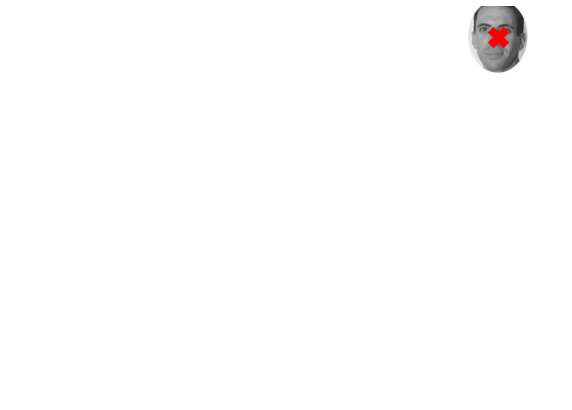

In [17]:
sentnames = list(D_sents_fixated.keys())
for i in range(len(sentnames)):
    print('Image %d/%d: %s'%(i,len(sentnames),sentnames[i]))
    plot_fixations_on_image(sentnames[i],D_sents_fixated[sentnames[i]])

## Plot average attention heatmaps (aggegated across participants) on top of images ##

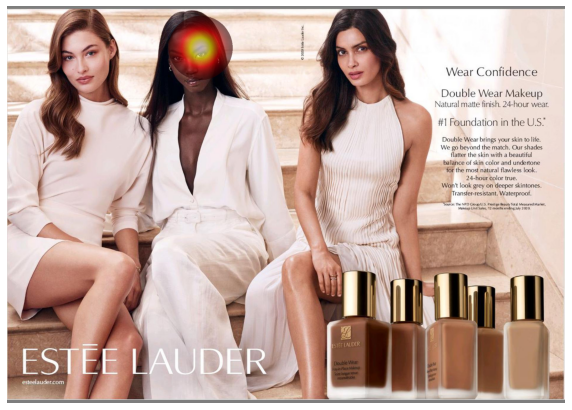

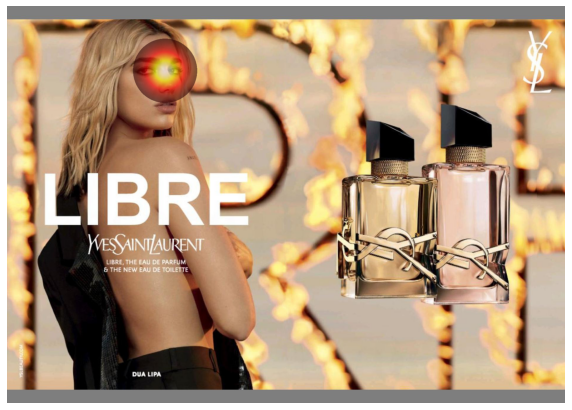

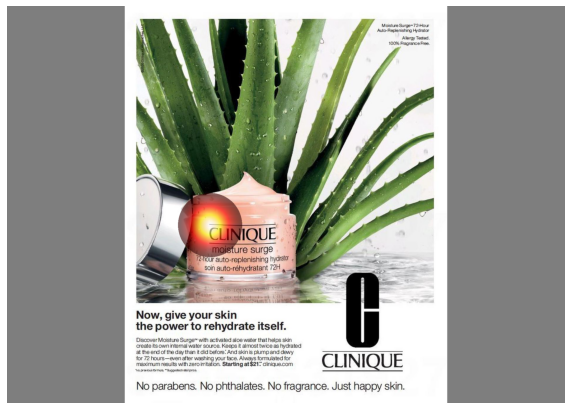

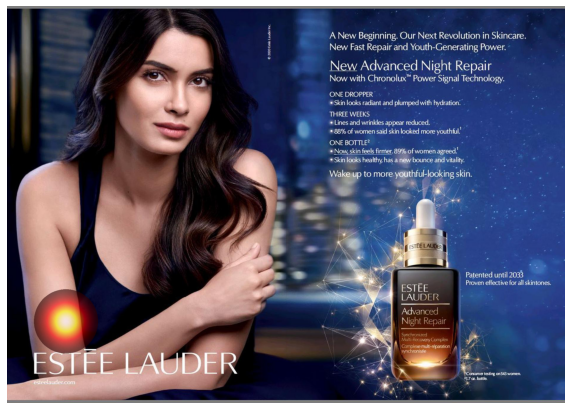

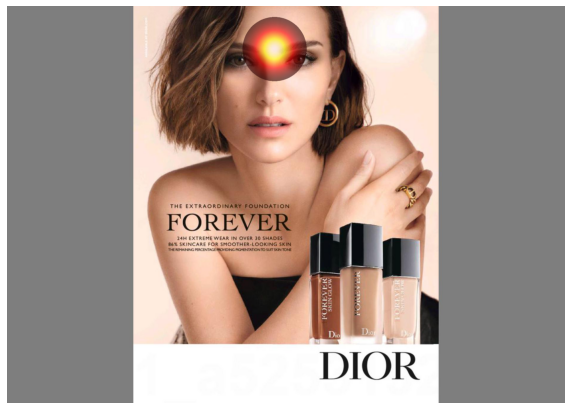

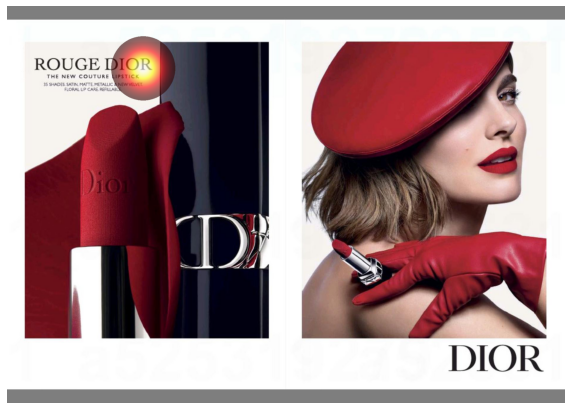

In [18]:
import spotlight as sp

# only visually meaningful if averaging the data of multiple participants 
#(here we show the visualization for 1 participant)

# convolve all locations with a gaussian (with selected sigma) to convert into a distribution

SIGMA = 45 # used for converting locations into maps (distributions)
def get_heatmap_for_image(filename,D,sigma=SIGMA,toplot=False):
    
    imfilename = os.path.join(base_path, filename)
    im = Image.open(imfilename).convert('RGB')
    [width,height] = im.size
    
    temp = np.zeros([height,width])
    for i in range(len(D)):
        coords = D[i]['coords']
        temp[coords[1],coords[0]] = 1
        
    res = scipy.ndimage.filters.gaussian_filter(temp,[sigma,sigma]);
    
    if toplot:
        plt.imshow(res);
    
    return res,im

imnames = list(D_coords_fixated.keys())
for i in range(len(imnames)):
    
    hm,im = get_heatmap_for_image(imnames[i],D_coords_fixated[imnames[i]],sigma=SIGMA,toplot=False)

    # different visualizations are possible (see the spotlight.py file)
    #vis = sp.spotlight(im,hm,toplot=False)
    vis = sp.heatmap_patches(im,hm)
    #vis = sp.heatmap_overlay(im,hm)
    
    fig,ax = plt.subplots(1,figsize=(10,10))
    ax.imshow(vis); plt.axis('off'); plt.show();
    